# `016` Transformers

Requirements: 014 Attention and dropout, 015 Residual connections

☢️☢️ WIP ☢️☢️

Attention mechanisms were proposed as a way to make the RNN inputs contain information about other terms in the sequence. This way, every sequence element can be contextualized properly with the information from other tokens. However, an architecture called transformer proposed by [Vaswani et al., 2017](ttps://arxiv.org/pdf/2002.04745v1.pdf) took the world by surprise.

Basically, he removed the RNN layers and used just a bunch of linear layers, attention mechanisms, residual connections and normalization. Applied in the context of German to English translation, the architecture achieved better quality (BLEU score) than any previous model. Furthermore, applying it over general text corpuses created a level of generalization pretty impressive and scalable with model size.

In this notebook I will define a transformer block, build a model with many of them, and train it over the Spanish novels corpus also used for the Embeddings notebook.

In [1]:
from matplotlib import pyplot as plt
from re import sub
from time import time
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
tokens = ' !(),-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz¡¿ÁÉÍÑÓÚÜáéíñóúü'
t2i = {c: i for i, c in enumerate(tokens)}
i2t = {i: c for i, c in enumerate(tokens)}

with open('custom-data/spanish-novels.txt', encoding='utf-8') as fp:
	data = fp.read()

data = sub(r'\s*\n\s*', ' ', data)
data = [t2i[c] for c in data if c in tokens]
data = torch.tensor(data, dtype=torch.long).to(device)
print(f'dataset size: {data.shape[0]} (that\'s like {100 * data.shape[0] / 20000000000000:.6f}% of GPT-4\'s training data)')

dataset size: 19263904 (that's like 0.000096% of GPT-4's training data)


In [107]:
def get_batch(size=32, context_size=64):
	starts = torch.randint(0, len(data) - context_size, (size,))
	x = torch.stack([data[s:s+context_size] for s in starts])
	y = torch.stack([data[s+context_size] for s in starts])
	return x, y

x, y = get_batch()
print(x.shape, y.shape)

torch.Size([32, 64]) torch.Size([32])


Now let's define the trasnformer block. This block can be understood like an individual step in the thinking process: first you pay attention to something specific (attention layer), and then you extract conclusions about it (linear layer).

To prevent vanishing/exploding gradients from happening, normalizations are added in between both. In the original transfomers paper batch normalization was used. However, batchnorm is annoying in that the elements in the batch have interdependencies when computing the average and standard deviation, so in practice approaches like LayerNorm or RMSNorm are used. RMSNorm stands for Root Mean Squared normalization, and it's as simple as squaring all the weights, adding them together, and dividng all weights by the root square of that number, so that the "vector" of weights becomes unitary (norm = 1).

Additionally, residual connections are added all over the model. This way, transformers can be thought as a main gradient highway that is the original value, and at each step we fork from that highway, do something, and merge back in.

In [108]:
class TransformerBlock(torch.nn.Module):
	def __init__(self, channels, num_heads, dropout):
		super().__init__()
		self.attention_heads = torch.nn.MultiheadAttention(channels, num_heads, dropout)
		self.norm1 = torch.nn.LayerNorm(channels)
		self.ff = torch.nn.Sequential(
			torch.nn.Linear(channels, channels),
			torch.nn.ReLU(),
			torch.nn.Dropout(dropout),
			torch.nn.Linear(channels, channels)
		)
		self.norm2 = torch.nn.LayerNorm(channels)

	def forward(self, x):
		attn_output, _ = self.attention_heads(x, x, x)
		x = x + attn_output
		x = self.norm1(x)
		ff_output = self.ff(x)
		x = x + ff_output
		x = self.norm2(x)
		return x

Now let's build the language model out of it. We'll basically just embed all tokens, pass them through a bunch of transformer layers, and then use a linear layer to output the logits of weights.

In [152]:
class LanguageModel(torch.nn.Module):
	def __init__(self, vocab_size, context_size=64, hidden_size=128, num_blocks=8, num_heads=4, dropout=.1):
		super().__init__()
		self.tok_emb = torch.nn.Embedding(vocab_size, hidden_size)
		self.pos_emb = torch.nn.Embedding(context_size, hidden_size)
		self.blocks = torch.nn.Sequential(*[
			TransformerBlock(hidden_size, num_heads, dropout)
			for _ in range(num_blocks)
		])
		self.out = torch.nn.Linear(context_size * hidden_size, vocab_size)

	def forward(self, x):
		x = self.tok_emb(x) + self.pos_emb(torch.arange(x.size(-1)))
		x = self.blocks(x)
		x = x.view(x.size(0), -1)
		return self.out(x)

model = LanguageModel(len(tokens))
print(f'Model has {sum(p.numel() for p in model.parameters())} parameters')

Model has 1411289 parameters


Let's now train our network to see how well it learns. One problem with these pretty deep neural networks with so many attention layers is that they need much lower learning rates, and hence many more training steps. This is one of the main problems that make training unfeasible in domestic computers in reasonable times anymore. For instance, training a GPT-2 level network requires about 16 hours in a cluster of 8 A100 GPUs as of 2024, which means spending around $200.

In [153]:
def train(model, epochs=3000, batch_size=32, context_size=64, lr=3e-4):
	model.train()
	optimizer = torch.optim.Adam(model.parameters(), lr=lr)
	losses = []
	start = time()
	for epoch in range(epochs):
		x_batch, y_batch = get_batch(size=batch_size, context_size=context_size)
		logits = model(x_batch)
		loss = torch.nn.functional.cross_entropy(logits, y_batch)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		losses.append(loss.item())
		if epoch % 300 == 0 and epoch > 0 or epoch == 50:
			remaining = (time() - start) * (epochs - epoch) / (epoch + 1)
			print(f'epoch {epoch:4d}, loss: {loss.item():6f}, remaining {remaining//60:.0f}m {remaining%60:2.0f}s')
	return losses

In [154]:
print('Gross training')
losses = train(model)
print('Fine training')
losses.extend(train(model, epochs=300, lr=3e-5))

Gross training
epoch   50, loss: 3.368922, remaining 4m  6s
epoch  300, loss: 3.277277, remaining 3m 24s
epoch  600, loss: 3.201486, remaining 2m 56s
epoch  900, loss: 3.028822, remaining 2m 37s
epoch 1200, loss: 2.709065, remaining 2m 15s
epoch 1500, loss: 2.555440, remaining 1m 52s
epoch 1800, loss: 2.005734, remaining 1m 31s
epoch 2100, loss: 2.459268, remaining 1m  9s
epoch 2400, loss: 2.559163, remaining 0m 46s
epoch 2700, loss: 2.168234, remaining 0m 23s
Fine training
epoch   50, loss: 2.037256, remaining 0m 18s


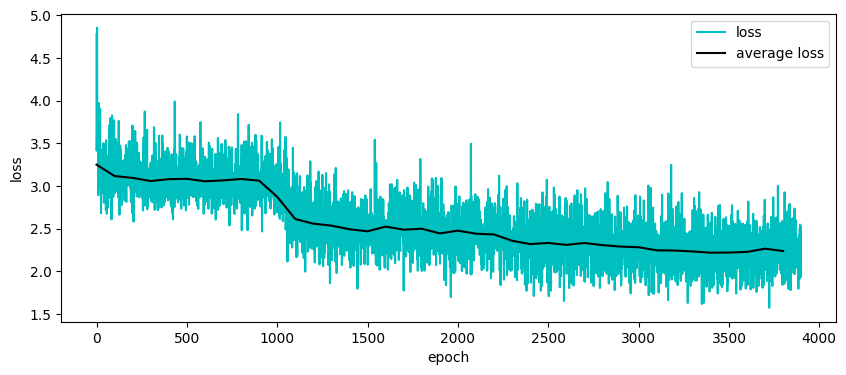

In [157]:
losses_avg = torch.tensor(losses).view(-1, 100).mean(1)
plt.figure(figsize=(10, 4))
plt.plot(losses, c='c', label='loss')
plt.plot(range(0, len(losses), 100), losses_avg, c='k', label='average loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [167]:
def complete(model, text, amount):
	tokens = [t2i[t] for t in text]
	for _ in range(amount):
		logits = model(torch.tensor([tokens[-64:]]))
		probs = logits.softmax(-1)
		tokens.append(torch.multinomial(probs, 1).item())
	print(''.join(i2t[i] for i in tokens))

In [168]:
complete(model, 'Esto es una prueba para ver qué tal funciona este método', 100)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x7168 and 8192x89)